## 1. Load the package

In [1]:
import os, shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from utils.labels_preprocessing import load_labels
from utils.load_synced_inputs import load_inputs
from utils.load_graphs import load_graph

from cnn_graph.resnetgraph import cgcnn
from cnn_graph import graph

import tensorflow as tf

from matplotlib import pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

## 2. Establish Directories for Data Extraction

In [2]:
home = f"{os.getcwd()}/.."

graphs_dir = f"{home}/Graphs/"            # directory containing necessary graphs
cortical_dir = '.../Data/abcd challenge/training/Cortex' # path for the ABCD cortical dataset
subcortical_dir = '.../Data/abcd challenge/training/Subcortex'# path for the ABCD subcortical dataset

for scan in os.listdir(cortical_dir):
    if scan[7:11] == 'NDAR':
        assert os.path.isfile(f"{subcortical_dir}/SubCortical_{scan[7:]}")

assert len(os.listdir(cortical_dir)) == len(set(os.listdir(cortical_dir)))

## 3. Load Labels

In [4]:
Path = '.../abcd.csv'
df = pd.read_csv(Path)
df_fluid = df[['Subject','Sex','Age','Cognition Fluid Composite Uncorrected Standard Score','Cognition Fluid Composite Age-Corrected Standard Score']]   # choose the columns you want
df_new = df_fluid.dropna(subset=['Cognition Fluid Composite Uncorrected Standard Score'])                                       # drop the Nan rows
df_new.head(8)

,Subject,Sex,Age,Cognition Fluid Composite Uncorrected Standard Score,Cognition Fluid Composite Age-Corrected Standard Score
0,NDAR_INV005V6D2C,F,121,90.0,90.0
1,NDAR_INV007W6H7B,M,126,101.0,104.0
2,NDAR_INV00CY2MDM,M,130,85.0,85.0
3,NDAR_INV00HEV6HB,M,124,90.0,88.0
4,NDAR_INV00LH735Y,M,109,77.0,75.0
5,NDAR_INV00LJVZK2,M,121,86.0,81.0
6,NDAR_INV00NPMHND,F,118,77.0,74.0
7,NDAR_INV00R4TXET,F,114,104.0,118.0


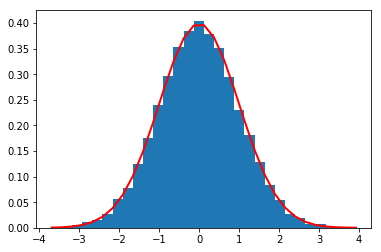

In [5]:
#show the distribution 
s = np.random.normal(0, 1, df_new.shape[0])
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/( np.sqrt(2 * np.pi)) *
                np.exp( - (bins )**2 / (2) ),
          linewidth=2, color='r')
plt.show()

In [6]:
def quantile_normalize_using_target(x, target):
    """
    Both `x` and `target` are numpy arrays of equal lengths.
    """

    target_sorted = np.sort(target)

    return target_sorted[x.argsort().argsort()]

In [7]:
xx = quantile_normalize_using_target(df_new['Cognition Fluid Composite Uncorrected Standard Score'].as_matrix(),s)
encoded_labels = xx
print(encoded_labels)

[-0.24633528  0.81573721 -0.69569488 ...  1.05993638  1.29075842
 -1.94937176]


In [8]:
df_new['CogFluidComp_nor'] = pd.DataFrame({'CogFluidComp_nor': xx})
df_new.head(8)

,Subject,Sex,Age,Cognition Fluid Composite Uncorrected Standard Score,Cognition Fluid Composite Age-Corrected Standard Score,CogFluidComp_nor
0,NDAR_INV005V6D2C,F,121,90.0,90.0,-0.246335
1,NDAR_INV007W6H7B,M,126,101.0,104.0,0.815737
2,NDAR_INV00CY2MDM,M,130,85.0,85.0,-0.695695
3,NDAR_INV00HEV6HB,M,124,90.0,88.0,-0.317715
4,NDAR_INV00LH735Y,M,109,77.0,75.0,-1.422254
5,NDAR_INV00LJVZK2,M,121,86.0,81.0,-0.630846
6,NDAR_INV00NPMHND,F,118,77.0,74.0,-1.416269
7,NDAR_INV00R4TXET,F,114,104.0,118.0,1.177185


In [9]:
filenames = df_new['Subject'].astype('str').as_matrix()
filenames2 = ('Cortex_' + filenames + '.mat').tolist()

In [10]:
filenames3 = [f for f in sorted(filenames2)]
print(filenames3[:10])

['Cortex_NDAR_INV005V6D2C.mat', 'Cortex_NDAR_INV007W6H7B.mat', 'Cortex_NDAR_INV00CY2MDM.mat', 'Cortex_NDAR_INV00HEV6HB.mat', 'Cortex_NDAR_INV00LH735Y.mat', 'Cortex_NDAR_INV00LJVZK2.mat', 'Cortex_NDAR_INV00NPMHND.mat', 'Cortex_NDAR_INV00R4TXET.mat', 'Cortex_NDAR_INV00U4FTRU.mat', 'Cortex_NDAR_INV00X2TBWJ.mat']


In [11]:
print(len(encoded_labels))

8070


## 4. Load Input Data (Cortical & SubCortical)

In [12]:
graph_type = {'cortical':{'path':cortical_dir, 
                          'parts':['white', 'pial'], 
                          'halves':True},
              
              'subcortical':{'path':subcortical_dir,
                             'parts':'all_sc', 
                             'halves':False}
             }
X = load_inputs(graph_type=graph_type, filenames = filenames2)

sub_graphs = list(graph_type.keys())
assert sub_graphs == ['cortical', 'subcortical']

Cortical	(Samples, Nodes, Feat.):	(8070, 32768, 6)
Subcortical	(Samples, Nodes, Feat.):	(8070, 14848, 3)


## 5. Analyze Distribution of Input Data for Both Surfaces

In [13]:
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])

## 6. MinMax Normalize Input Data

In [14]:
X_max = np.max(all_nodes)
X_min = np.min(all_nodes)

for sub in sub_graphs:
    X[sub] = (X[sub] - X_min) / (X_max - X_min)
    X[sub] *= 2
    X[sub] -= 1
del all_nodes   
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
del all_nodes

## 7. Block Diagonalize the Cortical Features with the SubCortical Features

In [16]:
from scipy.linalg import block_diag
from sklearn.utils import resample
new_X = []
for A,B in zip(X[f"cortical"], X[f"subcortical"]):
    new_X.append(block_diag(A,B))

In [17]:
del sub_graphs, xx, df

In [ ]:
X = np.concatenate([np.expand_dims(i, axis=0) for i in new_X], axis=0).astype('float32')

## 8. Split the training and validation dataset using Cross-validation

In [103]:
from sklearn.model_selection import KFold
import numpy as np

T  = [k for k in range(0,1332*5)]
T2= [i for i in range(1332*6, 8070)]
train_index = T2 + T
val_index = [j for j in range(1332*5, 1332*6)]
# print(train_dex)
# print(len(train_index))
X_train, X_val = X[train_index], X[val_index]
y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]


In [104]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6738, 47616, 9) (6738,) (1332, 47616, 9) (1332,)


## 9. Load Graph Adjacencies and Convert Into Laplacians

In [105]:
L = {}
L['cortical'] = load_graph(graphs_folder=graphs_dir, prefix='M_w')
L['cortical'] = [graph.laplacian(A) for A in L['cortical']]

L['subcortical'] = load_graph(graphs_folder=graphs_dir, prefix='M_sc_w')
L['subcortical'] = [graph.laplacian(A) for A in L['subcortical']]

## 10. Block Diagonalize the Cortical & Subcortical Laplacians at Each Level of Coarsening

In [106]:
from scipy.sparse import block_diag as sparse_block_diag

In [107]:
new_L = []
for A,B in zip(L[f"cortical"], L[f"subcortical"]):
    new_L.append( sparse_block_diag((A,B)) )
L = new_L
del new_L

## 11. ChebyNet Model Parameters Initialization

In [1]:
# Initial training parameters
params = {'num_epochs': 50, 
          'batch_size': 32,
          'eval_frequency': 10
         }

# Expected features dimension sizing of the input
N_feat = X_train.shape[-1]

params.update(task = 'regression')

if N_feat == 1:
    params['V'] = None
elif N_feat > 1:
    params['V'] = N_feat
else:
    raise ValueError('Input features dim. should be >= 1')

# # Network task initialization
# C = np.max(encoded_labels) + 1
# params.update(M = [C]) # number of units in fully-connected layer (set to # classes for classification)  
if params['task'] == 'classification':
    # Number of classes.()
    C = np.max(Gender) + 1
    assert C == np.unique(Gender).size
    params['M']              = [C]  # Set fully connected layer output to the number of class
else:
    arr = [0,0,0]
    C = np.max(arr) + 1    
    params['M']              = [C]

# Network Architecture
params['F']   = [16 for _ in range(4)] # number of filters per layer
params['K']   = 3                      # polynomial order of each layer
params['p']   = 2                      # pooling size per layer
params['B']   = len(params['F'])       # number of ResNet blocks
params['F_l'] = 128                     # number of post-ResNet filters

# Optimization Parameters
params['regularization'] = 0.
params['learning_rate']  = 5e-4
params['decay_rate']     = 0.999
params['momentum']       = 0.
params['dropout']        = 1.          # Using TF 1.13.1 so this is the KEEP PROBABILITY
params['decay_steps']    = 1.

# AUGMENTATION PROB. SET TO ZERO (NO AUGMENTATION)
params.update(prob_augment = 0.)

# Model Saving
params['dir_name'] = f"{home}/models/ABCD_CogFluidScore_val2"
# os.mkdir(params['dir_name'])
print(params['dir_name'])

## 12. Create Model

In [109]:
model = cgcnn(L, **params)

NN architecture
  input: M_0 = 47616
 
Pre-convolution layer:
  biases: L_0 * F_0_ = 47616 * 16 = 761856
  weights: V * F_0 * K_0 = 9 * 16 * 3 = 432
 
ResNet blocks:
 Block 0
    batch normalization: 2 * L_0 = 2 * 47616 = 95232
    weights: F_0 * F_0 * K_0 = 16 * 16 * 3 = 768
 Block 1
    batch normalization: 2 * L_1 = 2 * 23808 = 47616
    weights: F_1 * F_1 * K_1 = 16 * 16 * 3 = 768
 Block 2
    batch normalization: 2 * L_2 = 2 * 11904 = 23808
    weights: F_2 * F_2 * K_2 = 16 * 16 * 3 = 768
 Block 3
    batch normalization: 2 * L_3 = 2 * 5952 = 11904
    weights: F_3 * F_3 * K_3 = 16 * 16 * 3 = 768
 
Post-convolution layer:
  batch normalization: 2 * L_3 = 2 * 5952 = 11904
 
Fully connected layer:
  weights: K_3 * M = 3 * 1 = 3
L_post = 2976 ; F_post = 128 ; K_post = 3


## 13. Training 

In [2]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

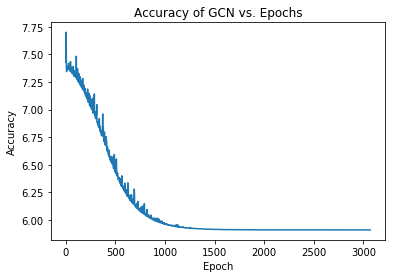

In [38]:
plt.plot(np.arange(0,1535*2,2),accuracy)
plt.title('Accuracy of GCN vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 14. CAM & Testing for each fold after training each fold

Size CAM_map = 6738 x 2976 x 1
Size CAM_pred = 32 x 2976 x 1
Begin = 0 ; End = 32
Size CAM_pred = 32 x 2976 x 1
Begin = 32 ; End = 64
Size CAM_pred = 32 x 2976 x 1
Begin = 64 ; End = 96
Size CAM_pred = 32 x 2976 x 1
Begin = 96 ; End = 128
Size CAM_pred = 32 x 2976 x 1
Begin = 128 ; End = 160
Size CAM_pred = 32 x 2976 x 1
Begin = 160 ; End = 192
Size CAM_pred = 32 x 2976 x 1
Begin = 192 ; End = 224
Size CAM_pred = 32 x 2976 x 1
Begin = 224 ; End = 256
Size CAM_pred = 32 x 2976 x 1
Begin = 256 ; End = 288
Size CAM_pred = 32 x 2976 x 1
Begin = 288 ; End = 320
Size CAM_pred = 32 x 2976 x 1
Begin = 320 ; End = 352
Size CAM_pred = 32 x 2976 x 1
Begin = 352 ; End = 384
Size CAM_pred = 32 x 2976 x 1
Begin = 384 ; End = 416
Size CAM_pred = 32 x 2976 x 1
Begin = 416 ; End = 448
Size CAM_pred = 32 x 2976 x 1
Begin = 448 ; End = 480
Size CAM_pred = 32 x 2976 x 1
Begin = 480 ; End = 512
Size CAM_pred = 32 x 2976 x 1
Begin = 512 ; End = 544
Size CAM_pred = 32 x 2976 x 1
Begin = 544 ; End = 576
Size 

Size CAM_pred = 32 x 2976 x 1
Begin = 4736 ; End = 4768
Size CAM_pred = 32 x 2976 x 1
Begin = 4768 ; End = 4800
Size CAM_pred = 32 x 2976 x 1
Begin = 4800 ; End = 4832
Size CAM_pred = 32 x 2976 x 1
Begin = 4832 ; End = 4864
Size CAM_pred = 32 x 2976 x 1
Begin = 4864 ; End = 4896
Size CAM_pred = 32 x 2976 x 1
Begin = 4896 ; End = 4928
Size CAM_pred = 32 x 2976 x 1
Begin = 4928 ; End = 4960
Size CAM_pred = 32 x 2976 x 1
Begin = 4960 ; End = 4992
Size CAM_pred = 32 x 2976 x 1
Begin = 4992 ; End = 5024
Size CAM_pred = 32 x 2976 x 1
Begin = 5024 ; End = 5056
Size CAM_pred = 32 x 2976 x 1
Begin = 5056 ; End = 5088
Size CAM_pred = 32 x 2976 x 1
Begin = 5088 ; End = 5120
Size CAM_pred = 32 x 2976 x 1
Begin = 5120 ; End = 5152
Size CAM_pred = 32 x 2976 x 1
Begin = 5152 ; End = 5184
Size CAM_pred = 32 x 2976 x 1
Begin = 5184 ; End = 5216
Size CAM_pred = 32 x 2976 x 1
Begin = 5216 ; End = 5248
Size CAM_pred = 32 x 2976 x 1
Begin = 5248 ; End = 5280
Size CAM_pred = 32 x 2976 x 1
Begin = 5280 ; End

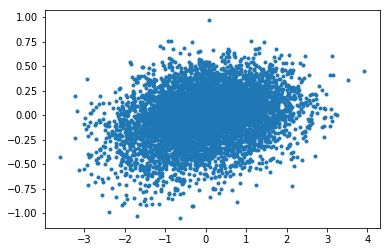

In [97]:
predictions, CAM_map = model.predict(X_train, CAM = True)
plt.plot(y_train, predictions, '.')

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res = r2_score(y_train,predictions)
print('r2', res)
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_train, predictions)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_train, predictions)
print('mse', mse)

In [101]:
print(CAM_map.shape)
np.save('path',CAM_map)

(0, 2976, 1)


Size CAM_map = 1332 x 2976 x 1
Size CAM_pred = 32 x 2976 x 1
Begin = 0 ; End = 32
Size CAM_pred = 32 x 2976 x 1
Begin = 32 ; End = 64
Size CAM_pred = 32 x 2976 x 1
Begin = 64 ; End = 96
Size CAM_pred = 32 x 2976 x 1
Begin = 96 ; End = 128
Size CAM_pred = 32 x 2976 x 1
Begin = 128 ; End = 160
Size CAM_pred = 32 x 2976 x 1
Begin = 160 ; End = 192
Size CAM_pred = 32 x 2976 x 1
Begin = 192 ; End = 224
Size CAM_pred = 32 x 2976 x 1
Begin = 224 ; End = 256
Size CAM_pred = 32 x 2976 x 1
Begin = 256 ; End = 288
Size CAM_pred = 32 x 2976 x 1
Begin = 288 ; End = 320
Size CAM_pred = 32 x 2976 x 1
Begin = 320 ; End = 352
Size CAM_pred = 32 x 2976 x 1
Begin = 352 ; End = 384
Size CAM_pred = 32 x 2976 x 1
Begin = 384 ; End = 416
Size CAM_pred = 32 x 2976 x 1
Begin = 416 ; End = 448
Size CAM_pred = 32 x 2976 x 1
Begin = 448 ; End = 480
Size CAM_pred = 32 x 2976 x 1
Begin = 480 ; End = 512
Size CAM_pred = 32 x 2976 x 1
Begin = 512 ; End = 544
Size CAM_pred = 32 x 2976 x 1
Begin = 544 ; End = 576
Size 

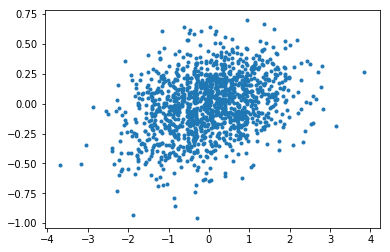

In [110]:
predictions, CAM_map = model.predict(X_val, CAM = True)
plt.plot(y_val, predictions, '.')

In [4]:
res = r2_score(y_val,predictions)
print('r2', res)
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_val, predictions)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_val, predictions)
print('mse', mse)

In [112]:
print(CAM_map.shape)
np.save('path',CAM_map)

(1332, 2976, 1)
